In [1]:
import numpy as np
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt 
import seaborn as sns

from glob import glob
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog

import PIL
import cv2
import pickle

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

### 예제 데이터

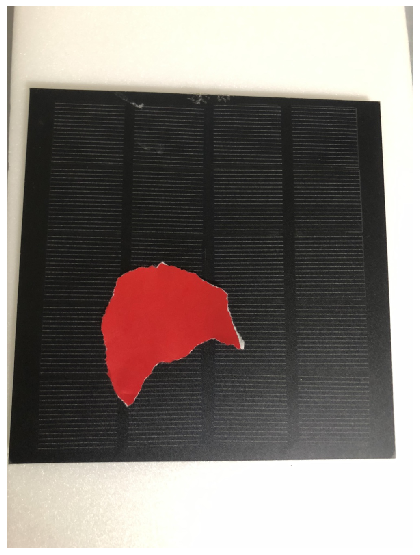

In [3]:
example_image = np.asarray(PIL.Image.open("C:/Users/jlee0/Desktop/KYU/hanim ict/탄소중립 항만/개발/dataset/KakaoTalk_20220821_200138523/KakaoTalk_20220821_200138523_00.jpg"))

fig = plt.figure(figsize=(16,16))
fig.add_subplot(1,2,1)
plt.imshow(example_image)
plt.axis("off")
plt.show()

### 데이터 추출

In [8]:
data_path = 'C:/Users/jlee0/Desktop/KYU/hanim ict/탄소중립 항만/개발/dataset'
number_of_class = len(os.listdir(data_path))

In [9]:
images = []
labels = []

start = time.time()

file_name = ['KakaoTalk_20220821_200138523','KakaoTalk_20220821_200204647','KakaoTalk_20220821_200242550','KakaoTalk_20220821_200300478','KakaoTalk_20220821_200338790','KakaoTalk_20220821_200356857']

for name in file_name:
    path = data_path + '/' + name
    images_path = os.listdir(path)
    for img_path in images_path:
        try:
            img = PIL.Image.open(path + '/' + img_path)
            img = img.resize((160,160))
            img = np.asarray(img)
            images.append(img)
        except:
            print('Error loading images')

In [10]:
x = np.asarray(images)

In [30]:
x.shape

(131, 160, 160, 3)

In [32]:
labels = []

for i in range(131):
    if i < 52:
        labels.append(2) #damage
    elif 51< i < 95:
        labels.append(1)
    else:
        labels.append(0)

In [33]:
y = np.asarray(labels)

In [76]:
y.shape

(131,)

In [79]:
target = np.array(pd.get_dummies(y))

In [107]:
np.argmax(target,axis =1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [80]:
count = 0
for i in range(len(y)):
    if y[i] == 0:
        count = count + 1
        
        
count

36

### 데이터 증강

In [81]:
def data_augmenter():

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

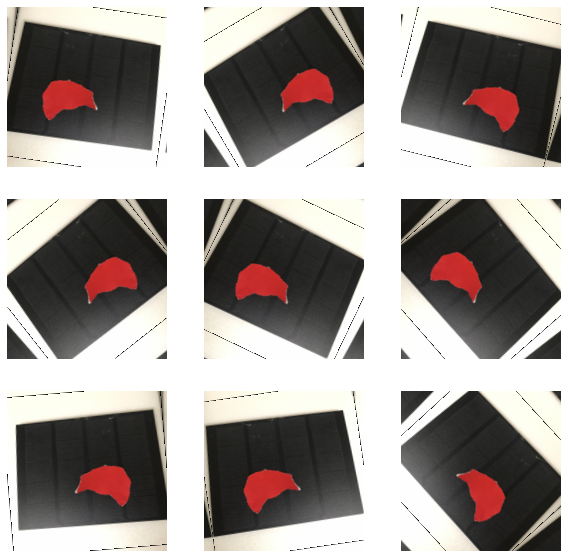

In [82]:
data_augmentation = data_augmenter()

plt.figure(figsize = (10,10))
first_image = x[0]
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image,0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [83]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### 선학습된 mobilenet로 모델링

In [84]:
IMG_SIZE = (160,160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [85]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [41]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d_2
predictions


In [86]:
base_model.trainable = False
image_var = tf.Variable(x,dtype = float)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04589890', 'window_screen', 0.8895724),
  ('n03485794', 'handkerchief', 0.011514221)],
 [('n04589890', 'window_screen', 0.4085362),
  ('n03485794', 'handkerchief', 0.079208516)],
 [('n04589890', 'window_screen', 0.6491727),
  ('n03485794', 'handkerchief', 0.06818506)],
 [('n04589890', 'window_screen', 0.23114829),
  ('n03485794', 'handkerchief', 0.11935595)],
 [('n04589890', 'window_screen', 0.6094881),
  ('n03485794', 'handkerchief', 0.105731905)],
 [('n04589890', 'window_screen', 0.21049187),
  ('n03485794', 'handkerchief', 0.14608043)],
 [('n04589890', 'window_screen', 0.50495195),
  ('n02834397', 'bib', 0.06590615)],
 [('n04589890', 'window_screen', 0.5432946),
  ('n03485794', 'handkerchief', 0.06883474)],
 [('n04589890', 'window_screen', 0.38613015),
  ('n03223299', 'doormat', 0.2088044)],
 [('n04589890', 'window_screen', 0.86545867),
  ('n04258138', 'solar_dish', 0.053592533)],
 [('n04589890', 'window_screen', 0.8248749),
  ('n04258138', 'solar_dish', 0.031948827)],
 [('n045

### pollution 데이터에 맞게 모델 재학습

In [92]:
def pollution_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape) 

    x = data_augmentation(inputs)
    
    x = preprocess_input(x) 

    x = base_model(x, training=False) 
    
    x = tfl.GlobalAveragePooling2D()(x) 

    x = tfl.Dropout(0.2)(x)
        
    prediction_layer = tfl.Dense(3)

    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [93]:
model2 = pollution_model(IMG_SIZE, data_augmentation)

In [96]:
base_learning_rate = 0.015
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [97]:
initial_epochs = 20
history = model2.fit(x,target, epochs=initial_epochs)

Epoch 1/20
5/5 [==============================] - 1s 234ms/step - loss: 0.2733 - accuracy: 0.8550
Epoch 2/20
5/5 [==============================] - 1s 237ms/step - loss: 0.3647 - accuracy: 0.8779
Epoch 3/20
5/5 [==============================] - 1s 248ms/step - loss: 0.2479 - accuracy: 0.9313
Epoch 4/20
5/5 [==============================] - 1s 273ms/step - loss: 0.2359 - accuracy: 0.9313
Epoch 5/20
5/5 [==============================] - 1s 268ms/step - loss: 0.2320 - accuracy: 0.9389
Epoch 6/20
5/5 [==============================] - 2s 320ms/step - loss: 0.2861 - accuracy: 0.8779
Epoch 7/20
5/5 [==============================] - 1s 236ms/step - loss: 0.4258 - accuracy: 0.8168
Epoch 8/20
5/5 [==============================] - 1s 242ms/step - loss: 0.3655 - accuracy: 0.9008
Epoch 9/20
5/5 [==============================] - 1s 250ms/step - loss: 0.4632 - accuracy: 0.8855
Epoch 10/20
5/5 [==============================] - 1s 259ms/step - loss: 0.3042 - accuracy: 0.8779
Epoch 11/20
5/5 [==

In [98]:
from keras.models import load_model

model2.save('pollution_classify_model.h5')

In [6]:
#0 값이 not-polluted, 1이 polluted
def model_predict(model,x):
    pred_labels = []
    
    image_var = tf.Variable(x,dtype = float)
    pred = model(image_var)
    
    pred = np.argmax(pred,axis =1)
    
    for i in range(len(pred)):
        if pred[i] == 2:
            pred_labels.append('damaged')
        elif pred[i] == 1:
            pred_labels.append('polluted')
        else:
            pred_labels.append('No problem')
    
    return pred, pred_labels

### 모델링 확인

기존 데이터 + 새로 찍은 데이터로 모델의 성능을 직접 확인해보겠다.

In [9]:
path = data_path + '/KakaoTalk_20220821_200204647/' + 'KakaoTalk_20220821_200204647_00.jpg'
img = PIL.Image.open(path)
img = img.resize((160,160))
img = np.asarray(img)

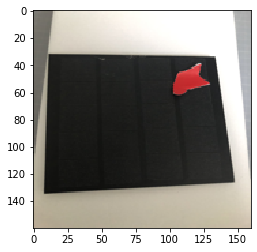

In [10]:
plt.imshow(img)

In [11]:
img.shape

(160, 160, 3)

In [12]:
img = img.reshape(1,160,160,3)
img.shape

(1, 160, 160, 3)

In [14]:
model_predict(model,img)

(array([2], dtype=int64), ['damaged'])

In [15]:
path = data_path + '/KakaoTalk_20220821_200300478/' + 'KakaoTalk_20220821_200300478_00.jpg'
img = PIL.Image.open(path)
img = img.resize((160,160))
img = np.asarray(img)

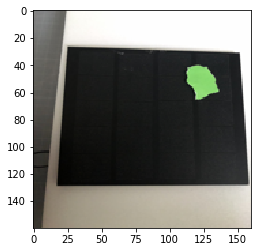

In [16]:
plt.imshow(img)

In [17]:
img = img.reshape(1,160,160,3)
img.shape

(1, 160, 160, 3)

In [18]:
model_predict(model,img)

(array([1], dtype=int64), ['polluted'])